In [296]:
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [297]:
def generate_dict(k, D):
    assert D % 2 == 0, "D doit être divisible par 2"
    letters = list(string.ascii_uppercase)
    assert k <= len(letters), "k ne doit pas dépasser 26"

    dico = {}

    # Ajout du token 'b' (begin)
    begin_half = np.random.randn(D // 2).astype(np.float32)
    begin_vec = np.concatenate([begin_half, np.zeros(D // 2, dtype=np.float32)])
    dico['b'] = begin_vec

    # Ajout des k lettres
    for i in range(k):
        key = letters[i]
        half = np.random.randn(D // 2).astype(np.float32)
        vec = np.concatenate([half, np.zeros(D // 2, dtype=np.float32)])
        dico[key] = vec

    return dico

In [298]:
T = 20
k = 5
D = 1000

In [299]:
dic = generate_dict(k, D)

In [300]:
def string_to_token(s):
    return np.array([dic[c] for c in s]).astype(np.float32)

In [301]:
def softmax(x, axis=None):
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

In [302]:

string_seq = ['b', 'C', 'C', 'C', 'A', 'E', 'A', 'A', 'B', 'D', 'B']
T = len(string_seq)

In [303]:
P = np.random.randn(T, D//2).astype(np.float32)
P = np.concatenate([P,np.zeros((T, D//2))], axis=1)

In [304]:
def permutation_matrix(D):
    assert D % 2 == 0, "D doit être pair"
    d_half = D // 2
    V = np.zeros((D, D))

    # Remplit les blocs pour permuter les deux moitiés
    V[:d_half, d_half:] = np.eye(d_half)  # Haut droit
    V[d_half:, :d_half] = np.eye(d_half)  # Bas gauche

    return V

In [305]:
def embedding(P, S):
    return P + S

In [306]:
def first_layer(P, S):
    X = embedding(P, S)
    QK1 = np.zeros((D,D), dtype=np.float32)
    for i in range(1, T):
        QK1 = QK1 + (P[i].reshape(D, 1) @ P[i-1].reshape(1, D))
    
    Att = X @ QK1 @ (X.T)/ np.linalg.norm(X @ QK1 @ (X.T)) * 20
    Att = softmax(Att, axis=1)
    V = permutation_matrix(D)
    Z = Z = (Att @ X @ V)/np.linalg.norm(Att @ X @ V)+X/np.linalg.norm(X)
    return Att, Z

In [307]:
Att1, Z1 = first_layer(P, string_to_token(string_seq))

In [308]:
def display_matrix(Att, string_seq):
    plt.figure(figsize=(8, 6))
    sns.heatmap(Att, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=string_seq, yticklabels=string_seq)
    plt.title("Attention Matrix")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()


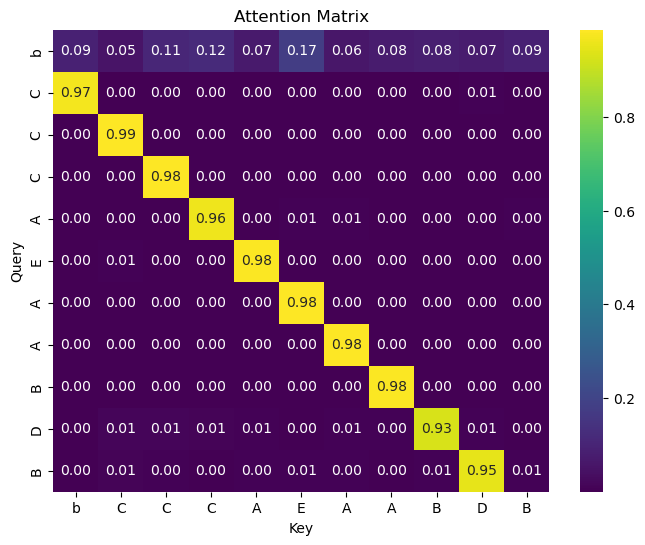

In [309]:
display_matrix(Att1, string_seq)

In [310]:
def second_layer(Z, beta=100):
    K_2 = np.zeros((D, D), dtype=np.float32)
    K_2[:D//2, D//2:] = np.eye(D//2)  
    Att2 = Z @ (K_2) @ (Z.T) *60
    Att2 = softmax(Att2, axis=1)
    V2 = beta* np.eye(D)
    Z2 = (Att2 @ Z @ V2)/np.linalg.norm(Att2 @ Z)
    return Att2, Z2


In [311]:
Att2, Z2 = second_layer(Z1)

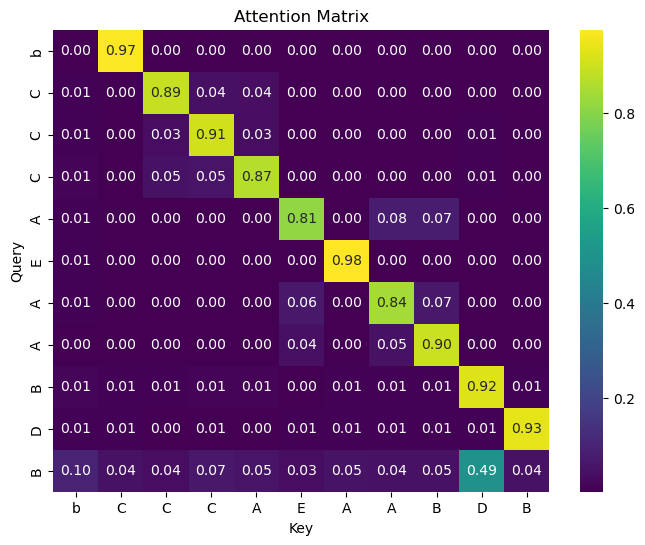

In [312]:
display(Att2, string_seq)

In [313]:
def classification(k, dico, Z):
    mlp = np.zeros((k, D), dtype=np.float32)
    letters = list(string.ascii_uppercase)
    for i in range(k):
        key = letters[i]
        mlp[i] = dico[key]
    logits = mlp @ Z[-1].T
    return softmax(logits)
    

In [314]:
classification_result = classification(k, dic, Z2)
print("Classification result", classification_result)

Classification result [1.83863332e-50 2.46446312e-63 1.53427195e-56 1.00000000e+00
 4.83994194e-82]


In [315]:
def generate_X_y(T, dico, n):
    """
    Génère n séquences (X, y) :
    - X est une séquence de T+1 lettres : 'b', ..., target (qui apparaît deux fois)
    - y est la lettre juste après la première apparition du target
    """
    assert 'b' in dico
    letters = [k for k in dico if k != 'b']
    assert len(letters) >= 2
    assert T >= 3, "T doit être au moins 3 pour que target puisse apparaître avant la fin et être suivi"

    X_list = []
    y_list = []

    for _ in range(n):
        seq = ['b']
        target = random.choice(letters)

        # Position du target dans le corps, garanti < T - 1
        insert_pos = random.randint(1, T - 2)

        middle_letters = []
        for i in range(1, T):
            if i == insert_pos:
                middle_letters.append(target)
            else:
                other_choices = [l for l in letters if l != target]
                middle_letters.append(random.choice(other_choices))

        seq.extend(middle_letters)
        seq.append(target)  # target en dernière position

        y = middle_letters[insert_pos]
        X_list.append(seq)
        y_list.append(y)

    return X_list, y_list


In [316]:
T = 10

In [317]:
def model(S):
    X = embedding(P, S)
    Att1, Z1 = first_layer(P, X)
    display_matrix(Att1, string_seq)
    Att2, Z2 = second_layer(Z1)
    logits = classification(k, dic, Z2)
    return logits

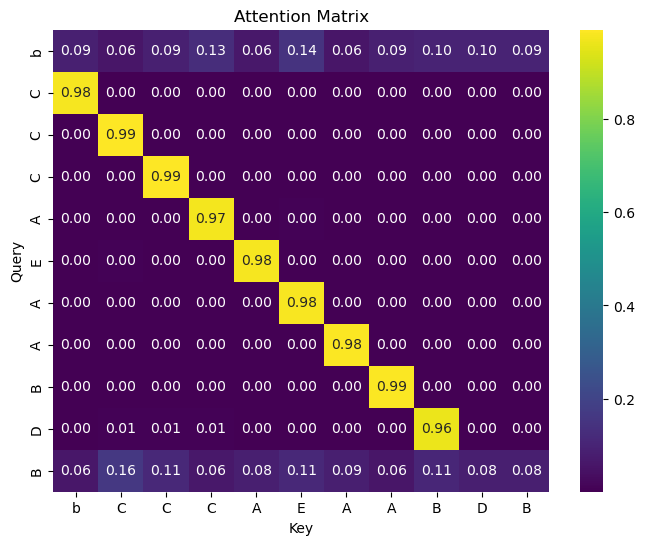

array([1.27668507e-05, 4.21361739e-08, 9.99986452e-01, 7.38667062e-07,
       1.43241548e-24])

In [318]:
model(string_to_token(string_seq))

In [319]:
import numpy as np

def display_predictions_numpy(X_seq, y_true, model, char_to_int, int_to_char):
    error = 0
    """
    X_seq : liste de séquences de lettres (taille n x (T+1))
    y_true : liste de lettres (taille n)
    model : fonction qui prend une séquence d'indices shape (n, T+1) → logits (n, k)
    char_to_int / int_to_char : dictionnaires de conversion
    """
    # Conversion des séquences X en entiers
    S = []
    for x in X_seq:
        S.append(string_to_token(x))
    for i, s in enumerate(S):
        print(s)
        logits = model(s)  # shape (n, k)
        print(logits)
        y_pred_idx = np.argmax(logits, axis=-1)
        x_letters = X_seq[i]
        true_letter = y_true[i]
        print(int_to_char)
        pred_letter = int_to_char[y_pred_idx]
        if true_letter != pred_letter:
            error += 1
        print(f"X: {x_letters} | y_true: {true_letter} | y_pred: {pred_letter}")
    print(f"Erreur : {error} sur {len(X_seq)} séquences")


In [320]:
X_seq, y = generate_X_y(T=10, dico=dic, n=1)

[[ 0.02540476 -0.28210154 -0.51943034 ...  0.          0.
   0.        ]
 [ 1.0429174  -0.29054493 -0.18567687 ...  0.          0.
   0.        ]
 [ 1.0429174  -0.29054493 -0.18567687 ...  0.          0.
   0.        ]
 ...
 [ 1.1020485   0.4260849   0.7866116  ...  0.          0.
   0.        ]
 [-2.227762    0.38832211  0.55085385 ...  0.          0.
   0.        ]
 [ 1.1020485   0.4260849   0.7866116  ...  0.          0.
   0.        ]]


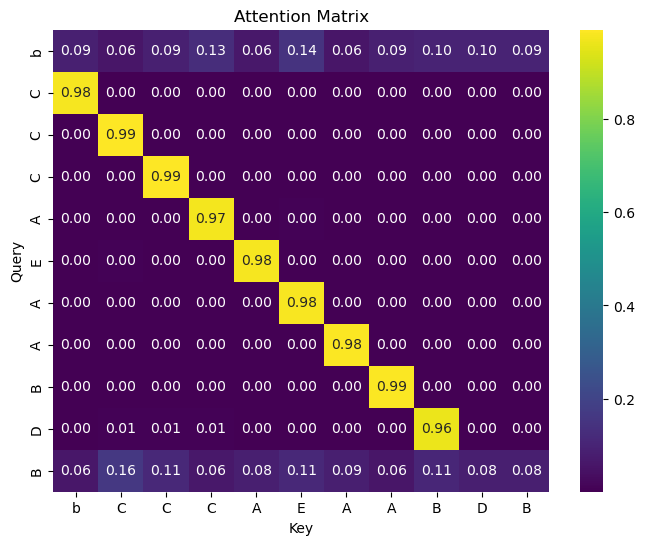

[1.27668507e-05 4.21361739e-08 9.99986452e-01 7.38667062e-07
 1.43241548e-24]
{0: 'b', 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E'}
X: ['b', 'C', 'C', 'C', 'A', 'E', 'A', 'A', 'B', 'D', 'B'] | y_true: A | y_pred: B
Erreur : 1 sur 1 séquences


In [321]:
char_to_int = {c: i for i, c in enumerate(dic)}
int_to_char = {i: c for c, i in char_to_int.items()}

X_seq = [string_seq]

display_predictions_numpy(X_seq, y, model, char_to_int, int_to_char)
